In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Matplotlib defaults
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(8,5), dpi=220)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


<Figure size 1760x1100 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv', index_col='id')

# Data Understanding

In [3]:
train.shape

(750000, 8)

In [4]:
test.shape

(250000, 7)

In [5]:
train.head(10)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,female,33,166.0,63.0,25.0,107.0,40.5,161.0


In [6]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [7]:
train.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


# Data Preprocessing

## Reducing memory usage

In [9]:
train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

In [10]:
train['Age'] = train['Age'].astype('int8')
test['Age'] = test['Age'].astype('int8')

In [11]:
num_cols = test.select_dtypes(include='float64').columns
for col in num_cols:
    train[num_cols] = train[num_cols].astype('float32')
    test[num_cols] = test[num_cols].astype('float32')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Sex         750000 non-null  category
 1   Age         750000 non-null  int8    
 2   Height      750000 non-null  float32 
 3   Weight      750000 non-null  float32 
 4   Duration    750000 non-null  float32 
 5   Heart_Rate  750000 non-null  float32 
 6   Body_Temp   750000 non-null  float32 
 7   Calories    750000 non-null  float64 
dtypes: category(1), float32(5), float64(1), int8(1)
memory usage: 27.2 MB


In [13]:
from sklearn.preprocessing import KBinsDiscretizer

kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
train['Kmeans_bins'] = kmeans.fit_transform(train[['Age']])
test['Kmeans_bins'] = kmeans.transform(test[['Age']])

# Feature Understanding via Data Visualization

<Axes: xlabel='Calories', ylabel='Count'>

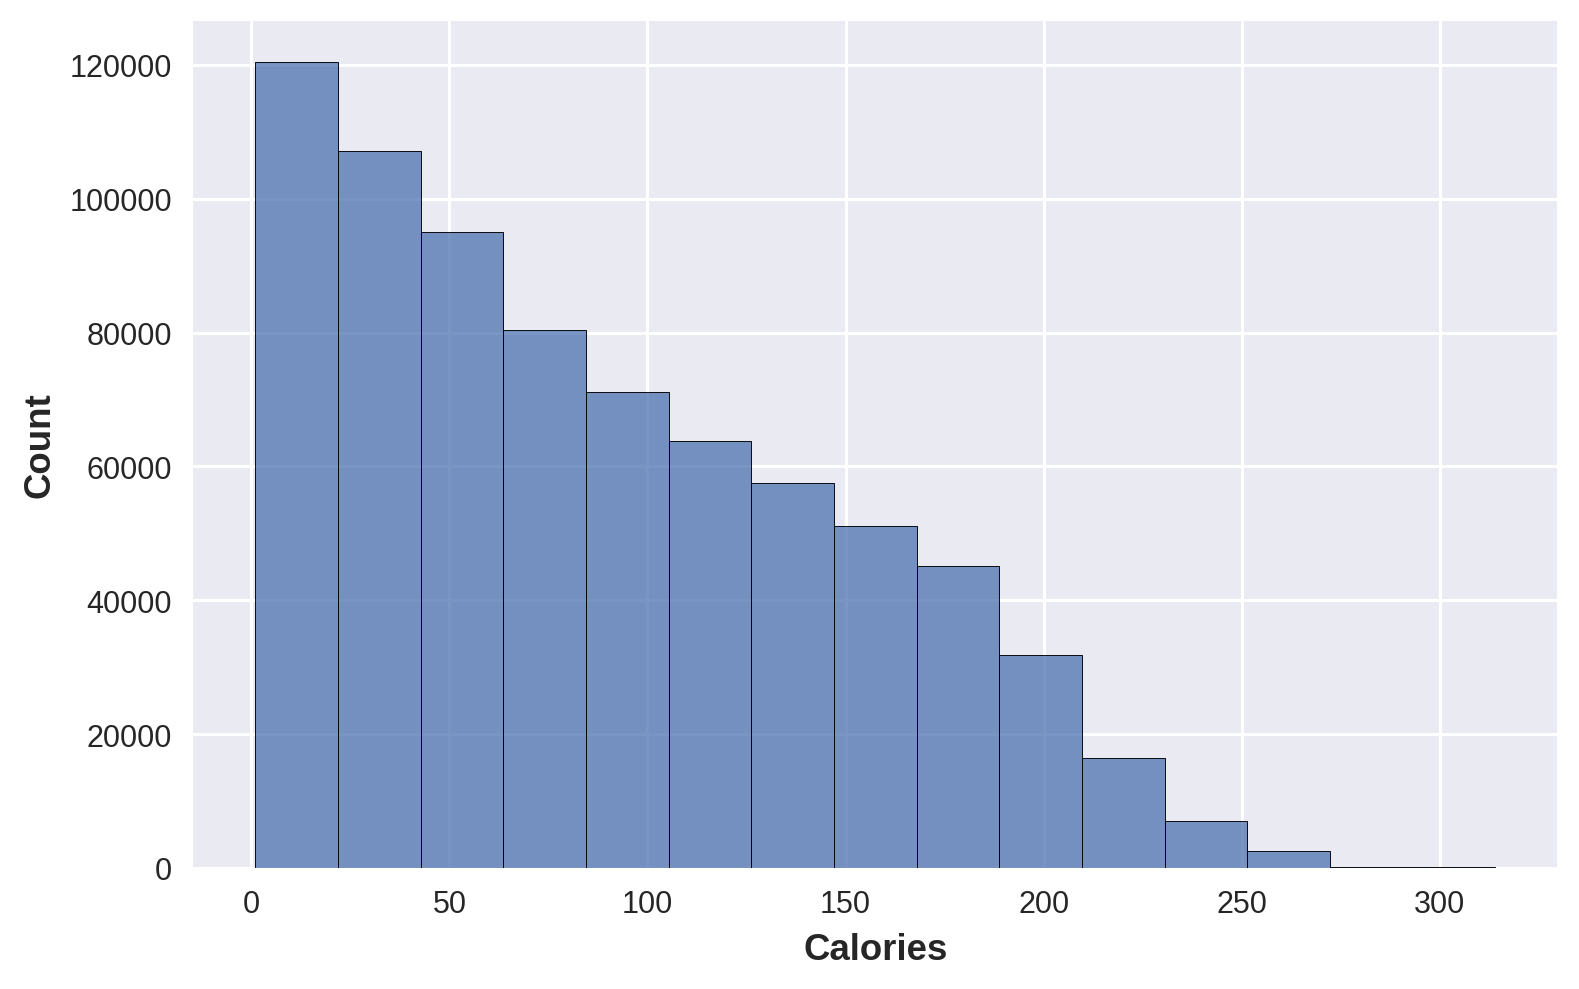

In [14]:
sns.histplot(x='Calories', bins=15, data=train, cbar=True)

<Axes: >

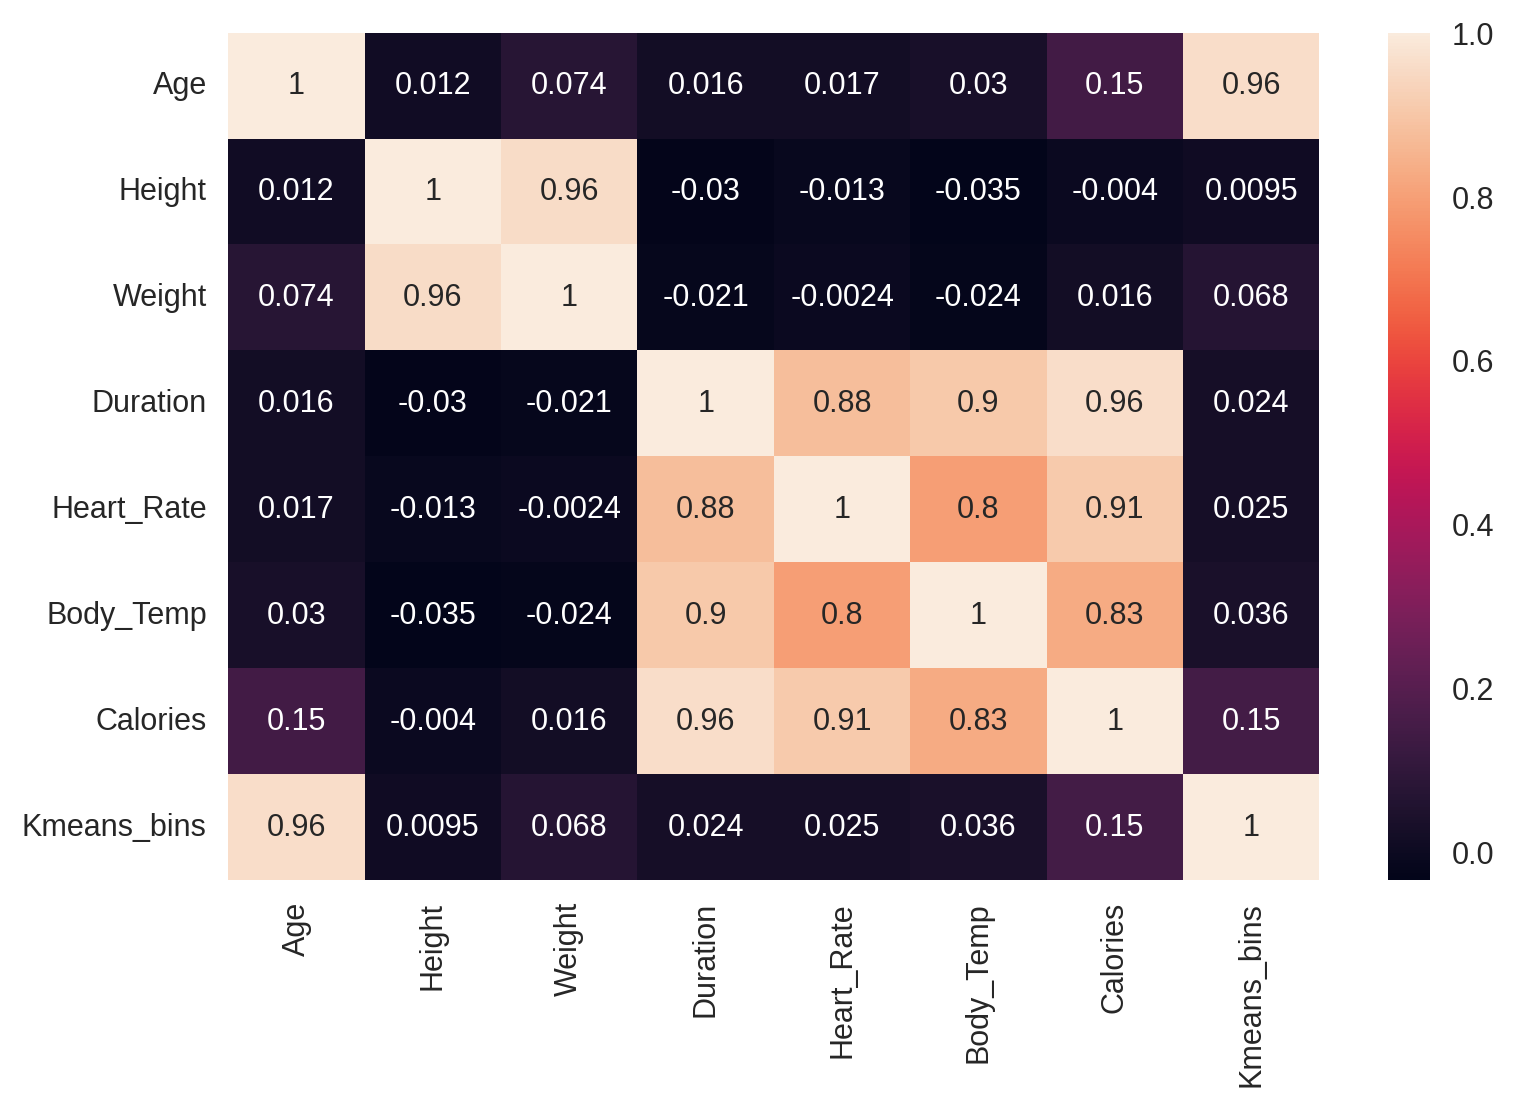

In [15]:
sns.heatmap(train.corr(numeric_only=True), annot=True)

In [16]:
train.columns

Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories', 'Kmeans_bins'],
      dtype='object')

In [17]:
features_selected = ['Age', 'Weight', 'Duration', 'Heart_Rate', 'Kmeans_bins']

In [18]:
X = train[features_selected]
y = train.Calories

X_test = test[features_selected].copy()

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

kf = KFold(n_splits=12, shuffle=True, random_state=100)
for fold, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.fit_transform(X_test)
    
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=15, random_state=100).fit(X_train, y_train, verbose=0)
    xgb_pred = xgb.predict(X_valid)
    
    fold_rmsle = np.sqrt(mean_squared_log_error(y_valid, xgb_pred))
    print(f"Fold {fold} RMSE: {fold_rmsle:.4f}")

Fold 1 RMSE: 0.0713
Fold 2 RMSE: 0.0723
Fold 3 RMSE: 0.0749
Fold 4 RMSE: 0.0718
Fold 5 RMSE: 0.0724
Fold 6 RMSE: 0.0713
Fold 7 RMSE: 0.0708
Fold 8 RMSE: 0.0749
Fold 9 RMSE: 0.0713
Fold 10 RMSE: 0.0725
Fold 11 RMSE: 0.0732
Fold 12 RMSE: 0.0720


In [20]:
test_xgb = xgb.predict(X_test)

sub = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sub['Calories'] = test_xgb
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
